# CKA Similarity Analysis
In this notebook we explore the CKA similarity metric with quantized models.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import pickle
import ast
import os
import sys


# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from CKA import CKA



## Utility methods

In [2]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()
    
def read_file(file_path, name='CKA_similarity'):
    
    file_path = os.path.join(file_path, f'{name}.pkl')
    
    try:
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        return result[name]
    except FileNotFoundError:
        print(f"File not found. ({file_path})")
    except Exception as e:
        print("Error occurred:", e)

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625, 0.0001, 0.00001, 0.000001, 0.0000001]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [4]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

## Result

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: ca

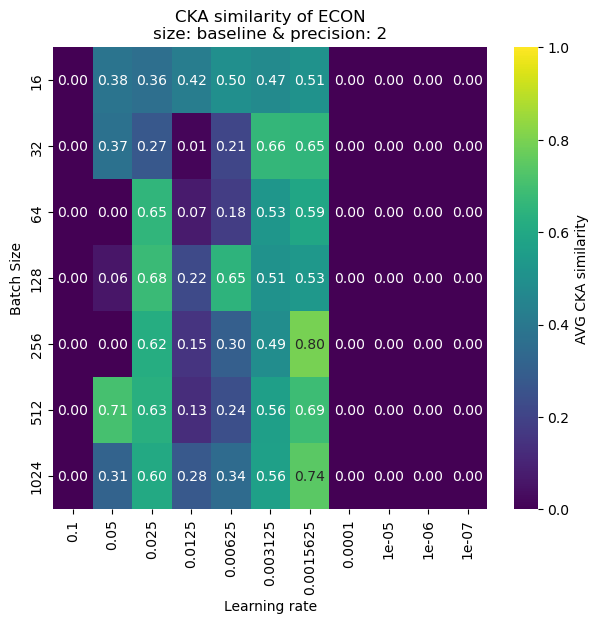

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_3b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_3b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_3b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_3b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


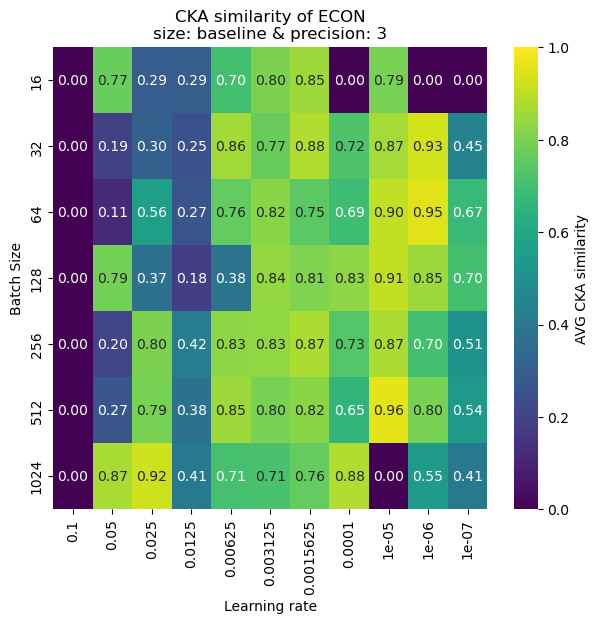

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_4b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_4b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_4b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_4b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


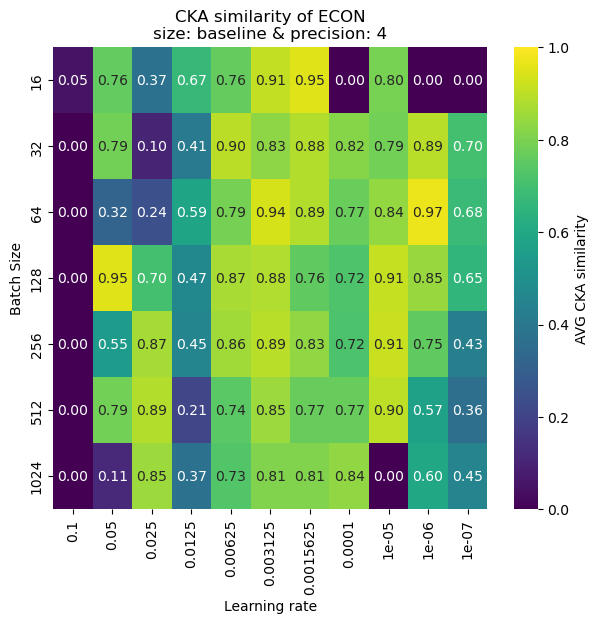

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_5b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_5b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_5b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_5b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


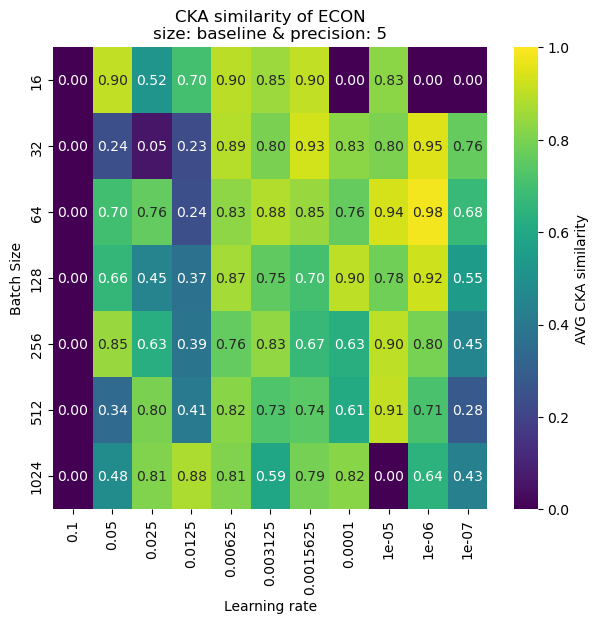

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_6b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_6b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_6b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_6b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


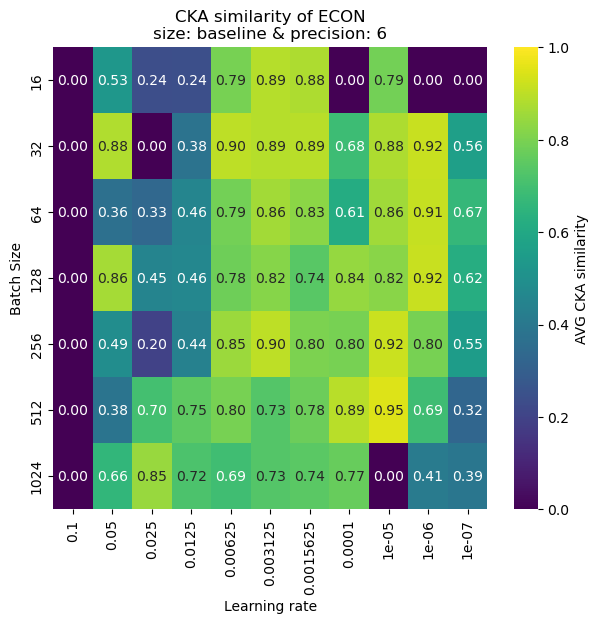

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_7b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_7b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_7b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_7b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


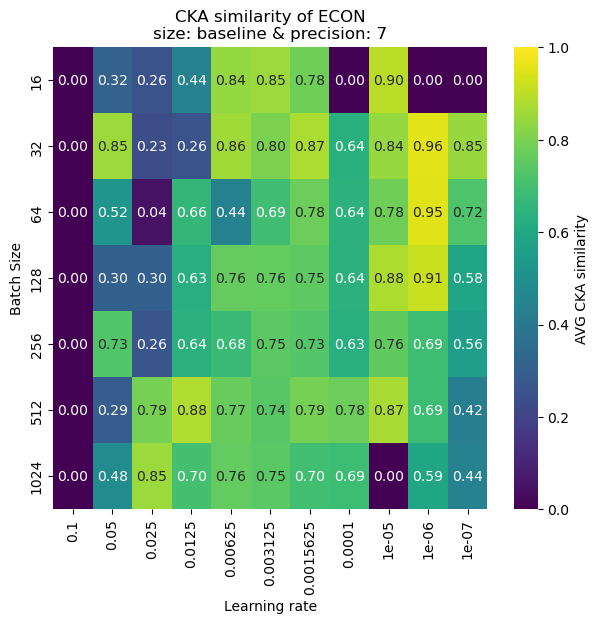

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_8b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_8b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_8b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_8b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


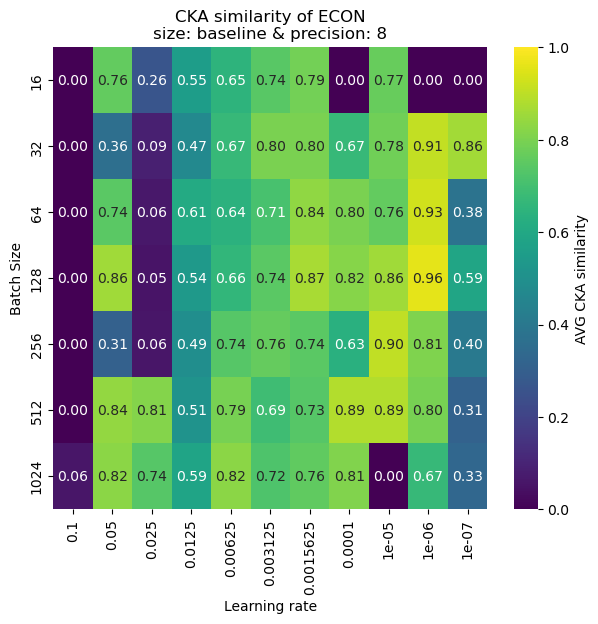

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_9b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_9b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_9b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_9b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


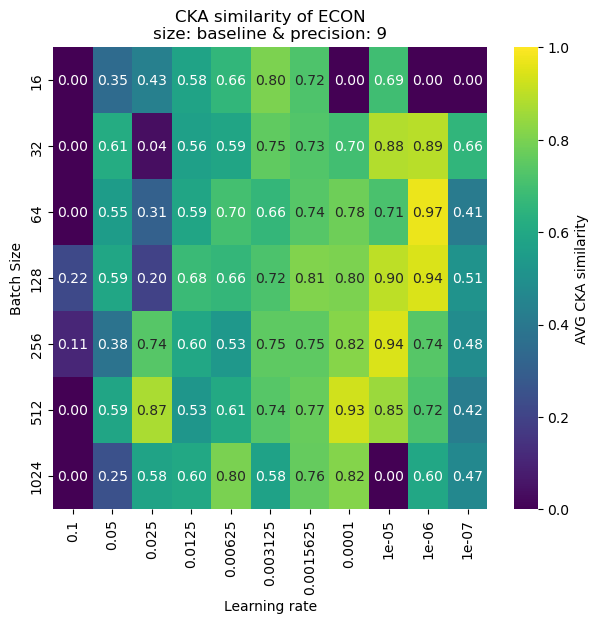

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_10b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_10b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_10b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_10b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


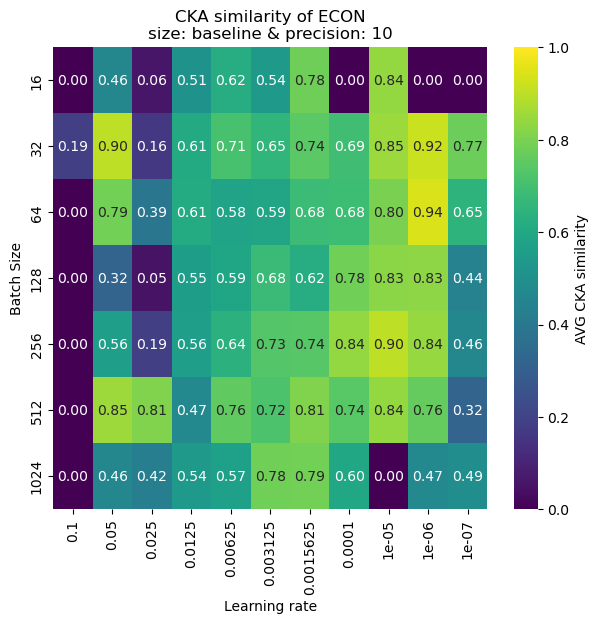

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_11b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_11b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_11b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_11b/baseline/CKA_similarity.pkl)
Error: cannot open the file!


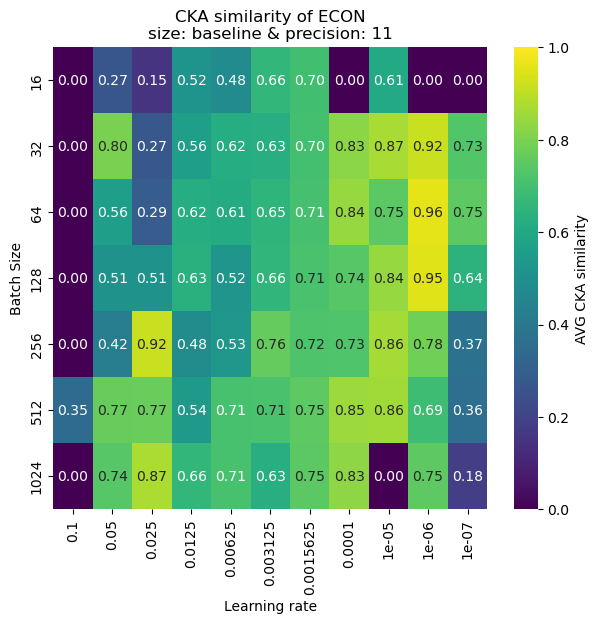

In [7]:
cka_distribution = []
for p in precisions:
    CKA_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # path to the directory
            lr = "{:.10f}".format(float(lr)).rstrip('0')
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
            avg_cka = 0
            try:
                result = read_file(path)
                avg_cka = result['CKA_similarity']
            except:
                print("Error: cannot open the file!")

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
            # build the dataframe for further analysis
            cka_distribution.append({
                'precision': p, 
                'avg_cka': avg_cka,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA similarity',
                    cmap='viridis')

In [ ]:
cka_distribution_df = pd.DataFrame(cka_distribution)
# export as CSV
cka_distribution_df.to_csv('./results/econ/cka.csv', index=False)

There is no correlation between the batch size and the robustness, so we want to plot it based onthe precision

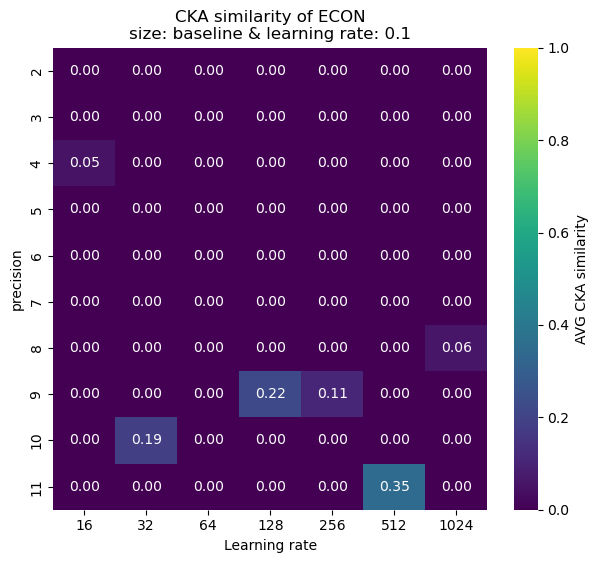

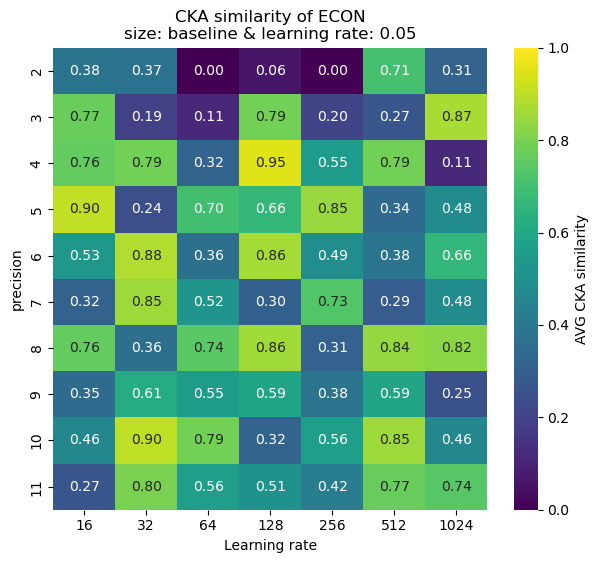

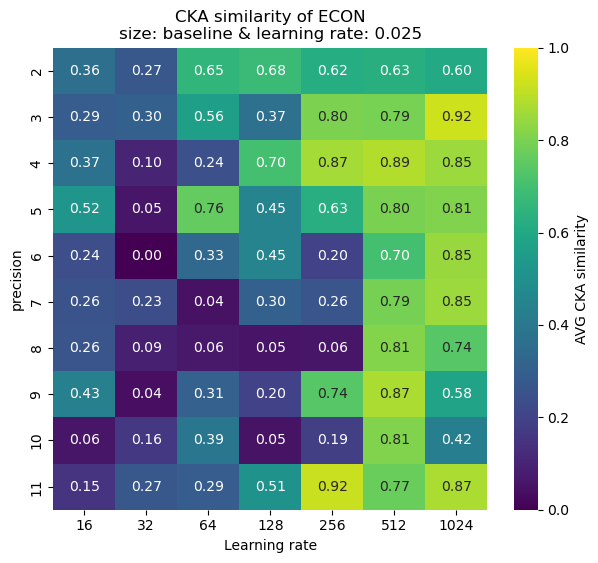

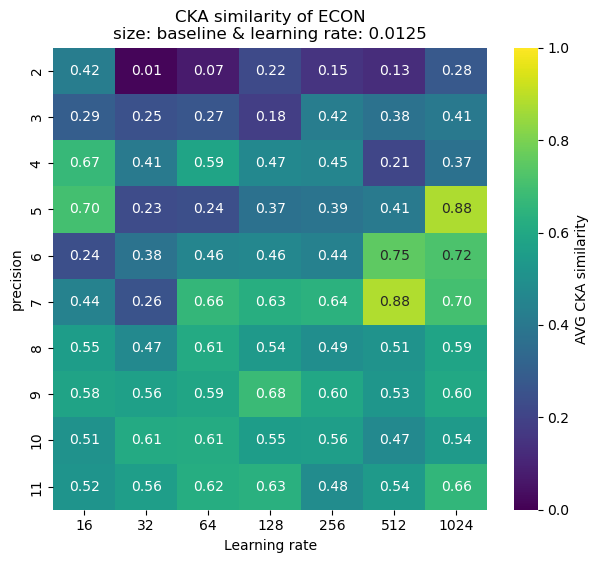

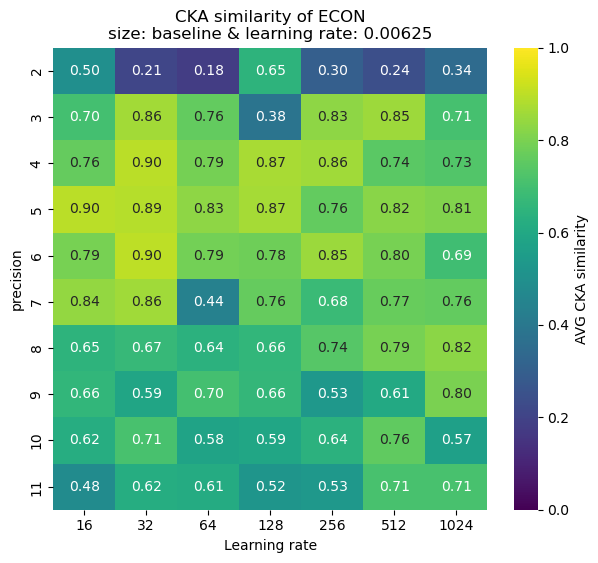

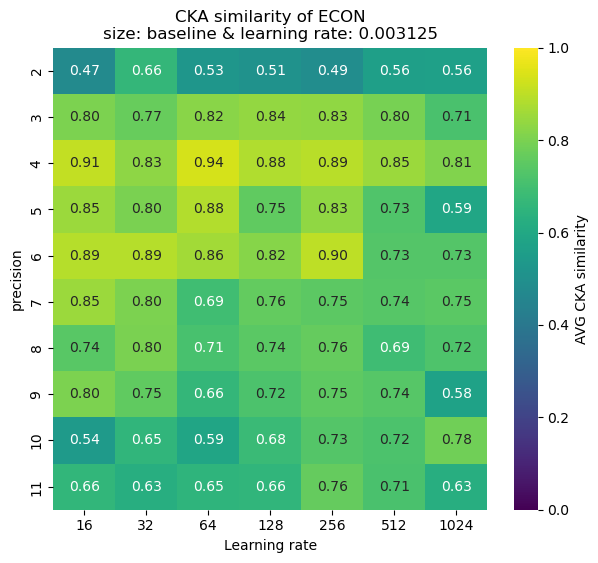

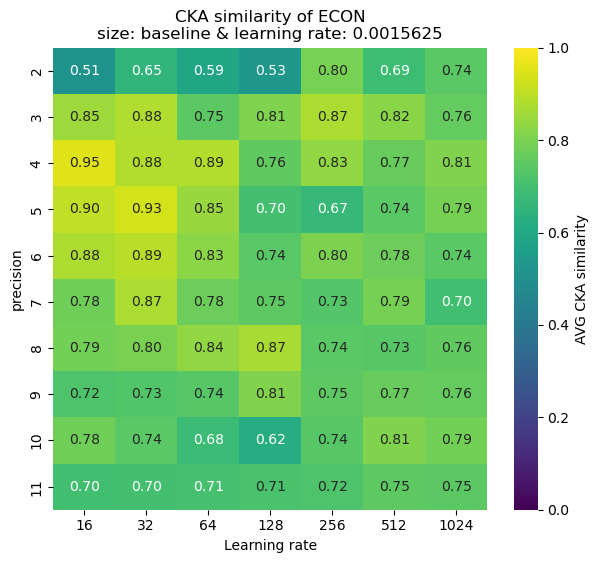

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs128_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs256_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.0001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0001/ECON_3b/baseline/CKA_similarity.pkl)
Error: cannot op

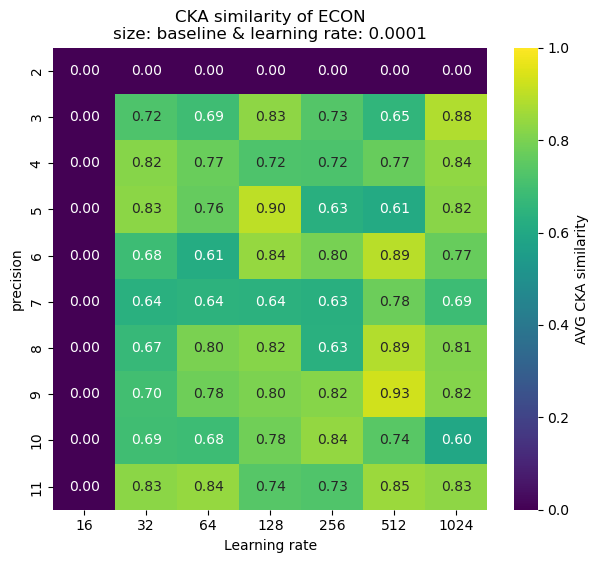

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs128_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs256_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.00001/ECON_3b/baseline/CKA_similarity.pkl)
Error:

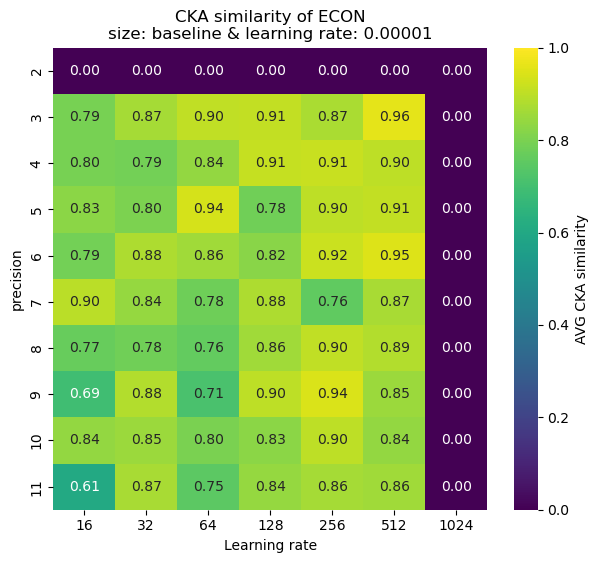

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs128_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs256_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.000001/ECON_3b/baseline/CKA_similarity.pkl)


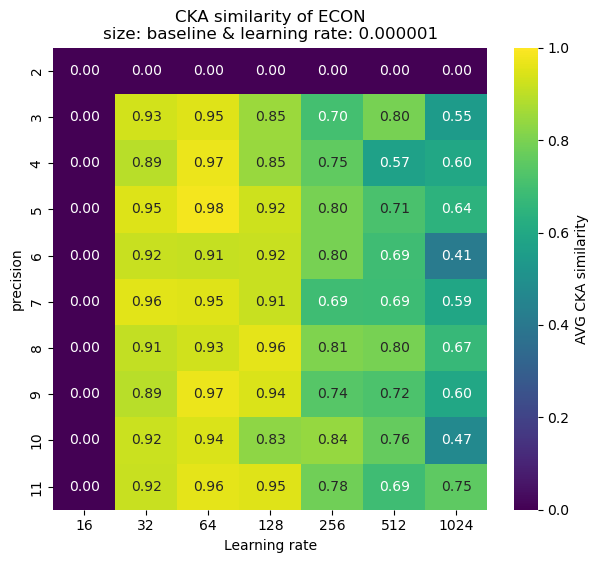

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs128_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs256_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs1024_lr0.0000001/ECON_2b/baseline/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0000001/ECON_3b/baseline/CKA_similari

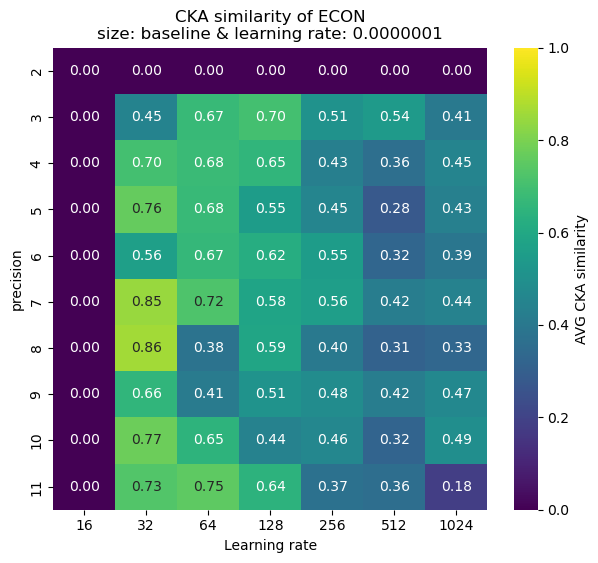

In [8]:
cka_distribution = []
for lr in learning_rates:
    CKA_matrix = np.zeros((len(precisions), len(batch_sizes)))
    for x, p in enumerate(precisions):
        for y, bs in enumerate(batch_sizes):
            # path to the directory
            lr = "{:.10f}".format(float(lr)).rstrip('0')
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
            avg_cka = 0
            try:
                result = read_file(path)
                avg_cka = result['CKA_similarity']
            except:
                print("Error: cannot open the file!")

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=precisions, 
                              columns=batch_sizes)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of ECON\nsize: {size} & learning rate: {lr}', 
                    (0, 1),
                    'Learning rate',
                    'precision',
                    'AVG CKA similarity',
                    cmap='viridis')

# RN08 (TinyResNet)

In [ ]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/RN08'

## Result

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_2b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_2b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_2b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_2b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_2b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_2b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_2b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_2b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.001

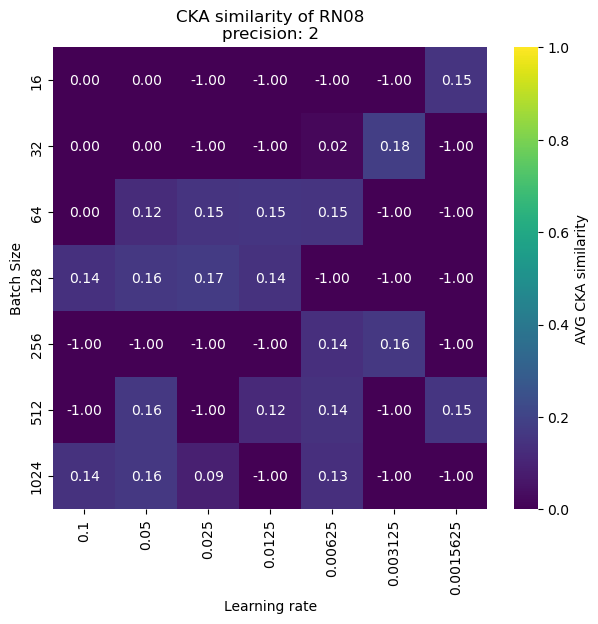

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_3b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_3b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_3b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_3b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_3b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_3b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_3b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_3b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.001

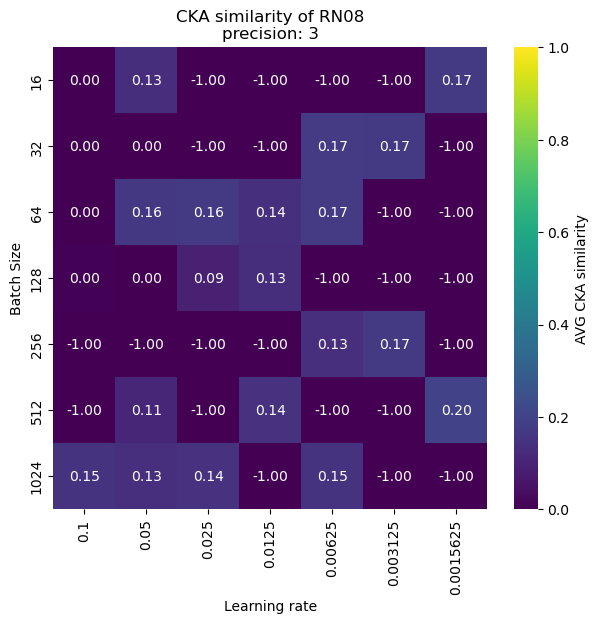

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_4b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_4b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_4b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_4b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_4b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_4b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_4b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_4b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.001

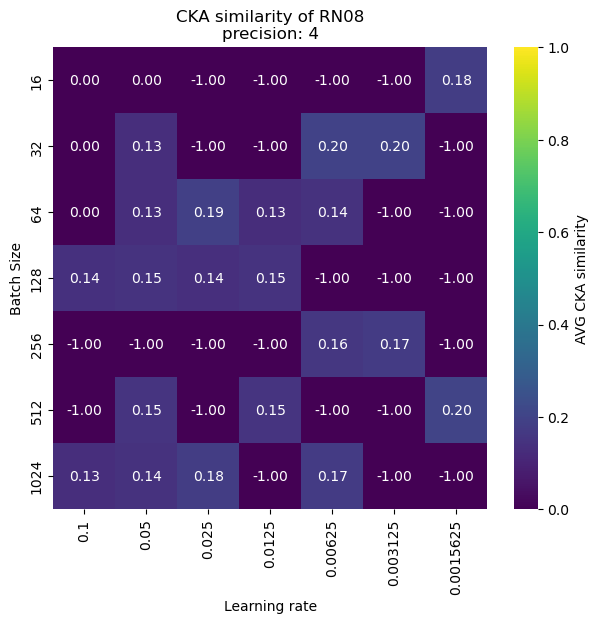

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_5b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_5b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_5b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_5b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_5b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_5b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_5b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_5b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.001

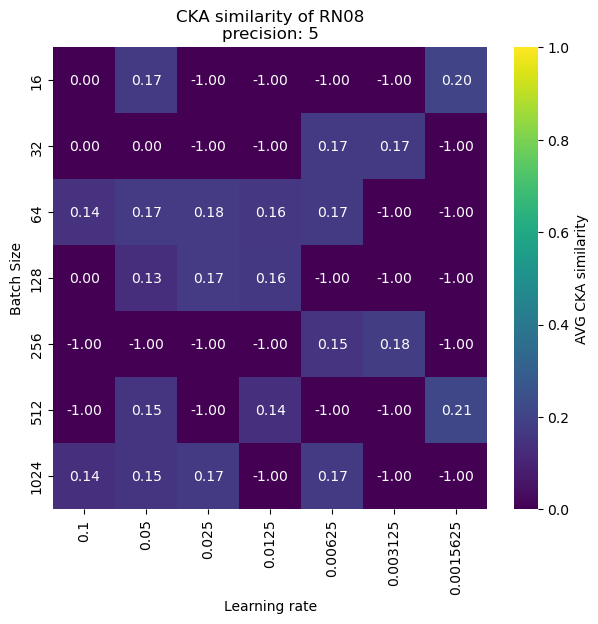

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_6b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_6b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_6b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_6b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_6b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_6b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_6b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_6b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.001

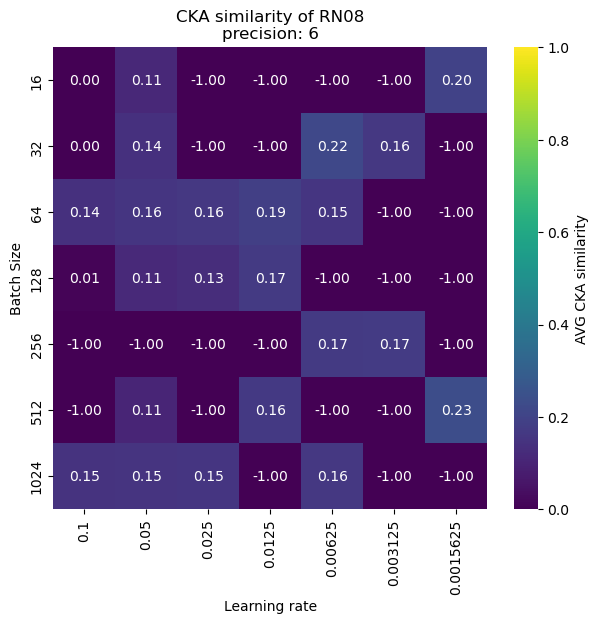

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_7b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_7b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_7b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_7b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_7b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_7b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_7b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_7b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.001

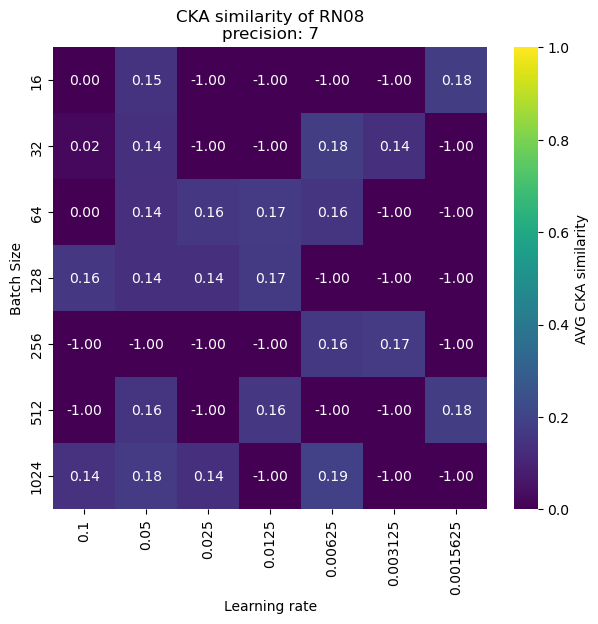

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_8b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_8b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_8b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_8b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_8b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_8b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_8b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_8b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.001

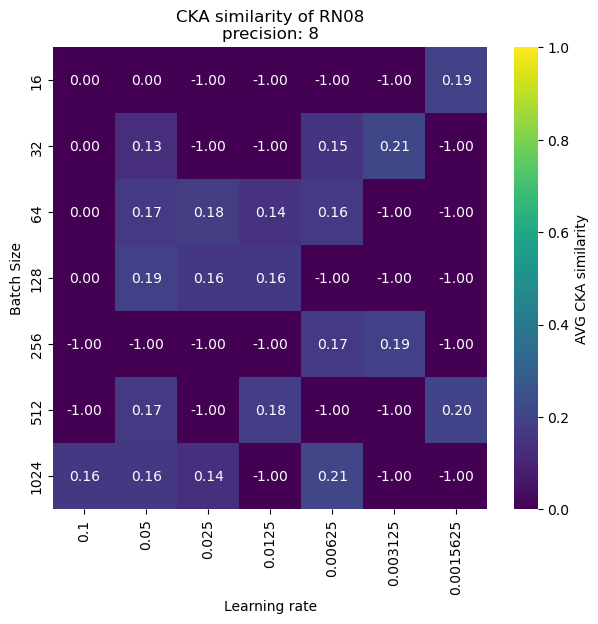

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_9b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_9b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_9b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_9b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_9b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_9b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_9b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_9b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.001

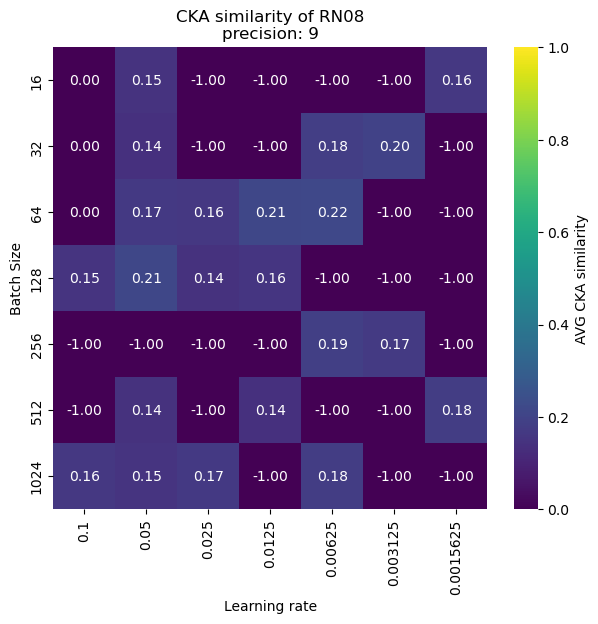

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_10b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_10b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_10b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_10b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_10b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_10b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_10b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_10b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64

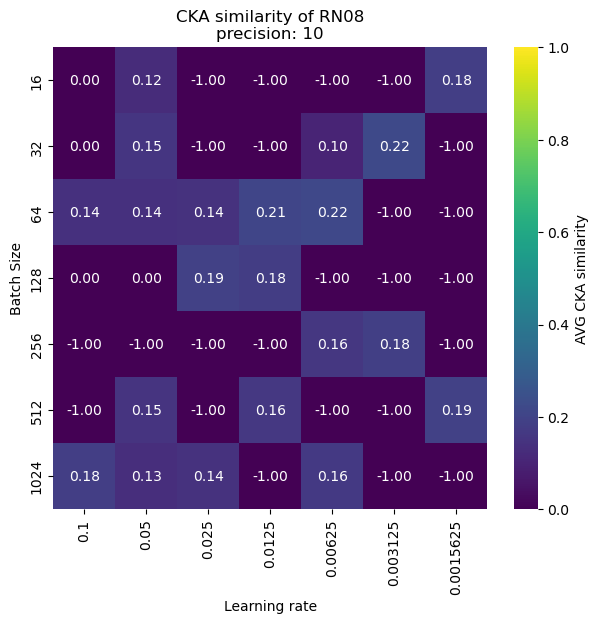

File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.025/RN08_11b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.0125/RN08_11b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.00625/RN08_11b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs16_lr0.003125/RN08_11b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.025/RN08_11b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0125/RN08_11b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/RN08_11b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64_lr0.003125/RN08_11b/CKA_similarity.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs64

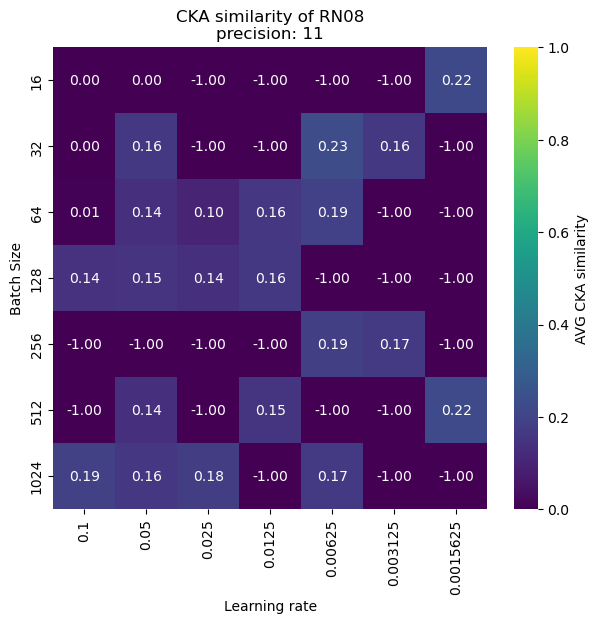

In [ ]:
cka_distribution = []
for p in precisions:
    CKA_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # path to the directory
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/RN08_{p}b/')
            avg_cka = -1
            try:
                result = read_file(path)
                avg_cka = result['CKA_similarity']
            except:
                print("Error: cannot open the file!")

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
            # build the dataframe for further analysis
            cka_distribution.append({
                'precision': p, 
                'avg_cka': avg_cka,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of RN08\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA similarity',
                    cmap='viridis')
    